In [1]:
import polars as pl
import polars.selectors as cs
from utils import PathsData, import_data, split_data, plot_correlation

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

x_validation = import_data(PathsData.X_TEST.value) #to use in the end to make a submission
x = import_data(PathsData.X_TRAIN.value)
y = import_data(PathsData.Y_TRAIN.value)

In [2]:
x_train, x_test, y_train, y_test = split_data(x=x, y=y)

In [3]:
x_train

train,gare,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4
str,str,str,i64,f64,f64,f64,f64,f64,f64
"""VBXNMF""","""KYF""","""2023-04-03""",8,0.0,0.0,1.0,-3.0,-1.0,-2.0
"""VBXNMF""","""JLR""","""2023-04-03""",9,0.0,0.0,0.0,1.0,0.0,1.0
"""VBXNMF""","""EOH""","""2023-04-03""",10,-1.0,0.0,0.0,-1.0,0.0,0.0
"""VBXNMF""","""VXY""","""2023-04-03""",11,-1.0,-1.0,0.0,2.0,-2.0,0.0
"""VBXNMF""","""OCB""","""2023-04-03""",12,-1.0,-1.0,-1.0,-1.0,3.0,2.0
…,…,…,…,…,…,…,…,…,…
"""AWCRYH""","""VXY""","""2023-10-03""",16,0.0,1.0,0.0,0.0,-2.0,0.0
"""AWCRYH""","""OCB""","""2023-10-03""",17,0.0,0.0,1.0,0.0,-2.0,0.0
"""AWCRYH""","""ZFB""","""2023-10-03""",18,1.0,0.0,0.0,0.0,-3.0,0.0


In [4]:
total = x_train.select('gare').to_series().value_counts().select('count').to_series().sum()
x_train.select('gare').to_series().value_counts().join(x_train, on = 'gare')

gare,count,train,date,arret,p2q0,p3q0,p4q0,p0q2,p0q3,p0q4
str,u32,str,str,i64,f64,f64,f64,f64,f64,f64
"""KYF""",23831,"""VBXNMF""","""2023-04-03""",8,0.0,0.0,1.0,-3.0,-1.0,-2.0
"""JLR""",25318,"""VBXNMF""","""2023-04-03""",9,0.0,0.0,0.0,1.0,0.0,1.0
"""EOH""",20828,"""VBXNMF""","""2023-04-03""",10,-1.0,0.0,0.0,-1.0,0.0,0.0
"""VXY""",22187,"""VBXNMF""","""2023-04-03""",11,-1.0,-1.0,0.0,2.0,-2.0,0.0
"""OCB""",23315,"""VBXNMF""","""2023-04-03""",12,-1.0,-1.0,-1.0,-1.0,3.0,2.0
…,…,…,…,…,…,…,…,…,…,…
"""VXY""",22187,"""AWCRYH""","""2023-10-03""",16,0.0,1.0,0.0,0.0,-2.0,0.0
"""OCB""",23315,"""AWCRYH""","""2023-10-03""",17,0.0,0.0,1.0,0.0,-2.0,0.0
"""ZFB""",14883,"""AWCRYH""","""2023-10-03""",18,1.0,0.0,0.0,0.0,-3.0,0.0


In [5]:
def frequency_encoding(x_train: pl.DataFrame, column: str):
    freq = x_train.select(column).to_series().value_counts()
    total = freq.select('count').to_series().sum()
    return (
        freq
        .with_columns(
            (pl.col("count") / total).alias(f"{column}_freq")
        )
        .drop("count")
    )

train_freq = x_train.pipe(frequency_encoding, column='train')
gare_freq = x_train.pipe(frequency_encoding, column='gare')

x_train_encoded = (
    x_train
    .with_columns(
        pl.col('date').str.strptime(pl.Date, format="%Y-%m-%d")
    )
    .with_columns(    
        pl.col('date').dt.year().alias('year'),
        pl.col('date').dt.month().alias('month'),
        pl.col('date').dt.day().alias('day')
    )
    # .with_columns(
    #     train_freq.select('train').to_series(),
    #     gare_freq.select('gare').to_series()
    # )
)

x_train_encoded = x_train_encoded.drop(['train', 'gare', 'date'])

print(x_train_encoded.head())


shape: (5, 10)
┌───────┬──────┬──────┬──────┬───┬──────┬──────┬───────┬─────┐
│ arret ┆ p2q0 ┆ p3q0 ┆ p4q0 ┆ … ┆ p0q4 ┆ year ┆ month ┆ day │
│ ---   ┆ ---  ┆ ---  ┆ ---  ┆   ┆ ---  ┆ ---  ┆ ---   ┆ --- │
│ i64   ┆ f64  ┆ f64  ┆ f64  ┆   ┆ f64  ┆ i32  ┆ i8    ┆ i8  │
╞═══════╪══════╪══════╪══════╪═══╪══════╪══════╪═══════╪═════╡
│ 8     ┆ 0.0  ┆ 0.0  ┆ 1.0  ┆ … ┆ -2.0 ┆ 2023 ┆ 4     ┆ 3   │
│ 9     ┆ 0.0  ┆ 0.0  ┆ 0.0  ┆ … ┆ 1.0  ┆ 2023 ┆ 4     ┆ 3   │
│ 10    ┆ -1.0 ┆ 0.0  ┆ 0.0  ┆ … ┆ 0.0  ┆ 2023 ┆ 4     ┆ 3   │
│ 11    ┆ -1.0 ┆ -1.0 ┆ 0.0  ┆ … ┆ 0.0  ┆ 2023 ┆ 4     ┆ 3   │
│ 12    ┆ -1.0 ┆ -1.0 ┆ -1.0 ┆ … ┆ 2.0  ┆ 2023 ┆ 4     ┆ 3   │
└───────┴──────┴──────┴──────┴───┴──────┴──────┴───────┴─────┘


c:\Users\faune\miniconda3\envs\challengedata\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\faune\miniconda3\envs\challengedata\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


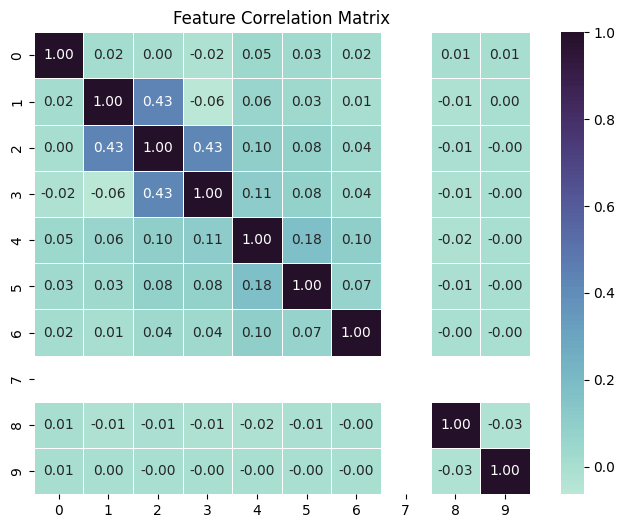

In [6]:
plot_correlation(x_train_encoded)

In [7]:
print(train_freq.head())
print(gare_freq.head())

shape: (5, 2)
┌────────┬────────────┐
│ train  ┆ train_freq │
│ ---    ┆ ---        │
│ str    ┆ f64        │
╞════════╪════════════╡
│ UEXSOJ ┆ 0.00003    │
│ ZQBFVG ┆ 0.000017   │
│ NGWZUD ┆ 0.000034   │
│ AWZYIG ┆ 0.000037   │
│ IMBXBV ┆ 0.00003    │
└────────┴────────────┘
shape: (5, 2)
┌──────┬───────────┐
│ gare ┆ gare_freq │
│ ---  ┆ ---       │
│ str  ┆ f64       │
╞══════╪═══════════╡
│ UAK  ┆ 0.021337  │
│ OCA  ┆ 0.009754  │
│ WJF  ┆ 0.00654   │
│ YWQ  ┆ 0.008516  │
│ ADU  ┆ 0.000112  │
└──────┴───────────┘
